#### **Цель работы:**

изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard. 

#### **Постановка задачи:**

1. Необходимо выбрать и подготовить датасет для классификации, затем построить классификационные модели с помощью пяти методов:

  - Наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

  - Деревья решений (Decision Tree);

- Линейный дискриминантный анализ (Linear Discriminant Analysis);

- Метод опорных векторов (Support Vector Machines);

- Метод ближайших соседей (k-Nearest Neighbors);

2. Затем сравните качество работы классификаторов с помощью следующих метрик:

- Accuracy (точность),

- Precision (доля правильно классифицированных положительных примеров),

- Recall (чувствительность, доля верно найденных положительных примеров),

- F1-Score (среднее гармоническое precision и recall),

- Площадь под кривой ROC (AUC-ROC).

3. Настройте гиперпараметры каждого метода и проведите исследование влияния различных параметров на качество классификации.

4. Реализуйте и протестируйте нейронную сеть на TensorFlow, исследуйте эффект настройки гиперпараметров и визуализируйте процесс обучения с помощью инструмента TensorBoard.

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay

from matplotlib.patches import Ellipse
from imblearn.over_sampling import SMOTE

initial_data = pd.read_csv('diabetes_dataset.csv', nrows=5000)

initial_data = initial_data.dropna()
print(initial_data)

      age  gender ethnicity education_level  income_level employment_status  \
0      58    Male     Asian      Highschool  Lower-Middle          Employed   
1      48  Female     White      Highschool        Middle          Employed   
2      60    Male  Hispanic      Highschool        Middle        Unemployed   
3      74  Female     Black      Highschool           Low           Retired   
4      46    Male     White        Graduate        Middle           Retired   
...   ...     ...       ...             ...           ...               ...   
4995   49    Male     White    Postgraduate  Lower-Middle          Employed   
4996   61  Female     White       No formal        Middle          Employed   
4997   90    Male     Asian      Highschool  Lower-Middle           Retired   
4998   63    Male     White      Highschool        Middle          Employed   
4999   36    Male     White      Highschool           Low           Retired   

     smoking_status  alcohol_consumption_per_week  

#### Датасет

Датасет представляет собой данные о людях и о диабете. В датасете есть 3 зависимых переменных для разных видов машинного обучения. Для классификации используется diagnosed_diabetes, принимающий значения 1 и 0 (Диагностирован диабет или нет).

В датасете 28 независимых признаков. Нужно отделить значимые признаки.


#### **Отбор признаков**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

initial_data = initial_data.drop(columns=['diabetes_stage', 'diabetes_risk_score'])

# Копируем данные
X = initial_data.drop('diagnosed_diabetes', axis=1).copy()
y = initial_data['diagnosed_diabetes']

# Если есть категориальные признаки, кодируем их
le = LabelEncoder()
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest важность
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importance:")
print(feature_importance.head())

X = initial_data[feature_importance[feature_importance['importance'] > 0.01]['feature']]

feature_importance[feature_importance['importance'] > 0.01]

X

Random Forest Feature Importance:
                               feature  importance
27                               hba1c    0.440095
25                glucose_postprandial    0.190556
24                     glucose_fasting    0.095866
8   physical_activity_minutes_per_week    0.018283
15                                 bmi    0.017804


,hba1c,glucose_postprandial,glucose_fasting,physical_activity_minutes_per_week,bmi,screen_time_hours_per_day,triglycerides,insulin_level,cholesterol_total,age,diet_score,ldl_cholesterol,systolic_bp,hdl_cholesterol,sleep_hours_per_day,heart_rate,diastolic_bp,waist_to_hip_ratio
0,8.18,236,136,215,30.5,7.9,145,6.36,239,58,5.7,160,134,41,7.9,68,78,0.89
1,5.63,150,93,143,23.1,8.7,30,2.00,116,48,6.7,50,129,55,6.5,67,76,0.80
2,7.51,195,118,57,22.2,8.1,36,5.07,213,60,6.4,99,115,66,10.0,74,73,0.81
3,9.03,253,139,49,26.8,5.2,140,5.28,171,74,3.4,79,120,50,6.6,68,93,0.88
4,7.20,184,137,109,21.2,5.0,160,12.74,210,46,7.2,125,92,52,7.4,67,67,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.86,200,131,183,24.9,5.0,120,10.29,132,49,7.7,53,131,48,6.2,73,70,0.86
4996,6.45,156,102,226,28.0,3.1,68,10.41,217,61,4.6,156,129,39,8.7,55,83,0.89
4997,7.09,175,133,67,23.8,7.8,170,10.56,225,90,8.2,151,149,56,4.3,72,83,0.88
4998,7.39,178,115,92,27.5,3.4,175,11.09,175,63,4.0,105,125,37,8.8,68,79,0.84


##### Были построенные деревья с помощью метода Random Forest, и так мы получили значимость для каждого признака. Возьмем признаки у которых значимость больше 0.01


Распределение по классам:
diagnosed_diabetes
1    3025
0    1975
Name: count, dtype: int64


C:\Users\maksg\AppData\Local\Temp\ipykernel_18056\3298687398.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=initial_data, x='diagnosed_diabetes', palette=['green', 'yellow'])


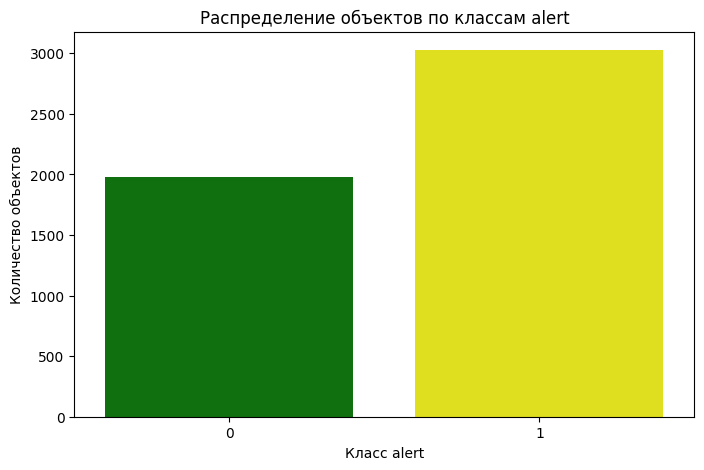

In [18]:
class_distribution = initial_data['diagnosed_diabetes'].value_counts()
print("Распределение по классам:")
print(class_distribution)

# 2. Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(data=initial_data, x='diagnosed_diabetes', palette=['green', 'yellow'])
plt.title('Распределение объектов по классам alert')
plt.xlabel('Класс alert')
plt.ylabel('Количество объектов')
plt.show()

#### Общие методы для расчета метрик и вывода матрицы:

In [19]:
from sklearn.metrics import roc_curve


def get_metrics(model, X_test, y_test, name = ''):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'model': name
    }
    
    figsize=(10, 8)
    if y_proba is not None:
        roc_auc =  roc_auc_score(y_test, y_proba)
        metrics['roc_auc'] = roc_auc
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
            
        plt.figure(figsize=figsize)
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC кривая {name} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                    label='Случайный классификатор')
            
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title(f'ROC-кривая: {name}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
            
            # Добавляем точку оптимального порога (ближайшая к (0,1))
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, 
                    label=f'Оптимальный порог: {optimal_threshold:.3f}')
        plt.legend()
            
        plt.tight_layout()
        plt.show()
    
    return metrics

total_metrics = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])


def show_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Нет диабета', "Eсть диабет"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Матрица ошибок - Decision Tree', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    

## **Наивный Байесовский классификатор**

#### Наивный байесовский классификатор (Naive Bayes classifier) — вероятностный классификатор на основе формулы Байеса со строгим (наивным) предположением о независимости признаков между собой при заданном классе, что сильно упрощает задачу классификации из-за оценки одномерных вероятностных плотностей вместо одной многомерной.

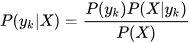

- P(yk|X) — апостериорная вероятность принадлежности образца к классу yk с учётом его признаков X;

- P(X|yk) — правдоподобие, то есть вероятность признаков X при заданном классе yk;

- P(yk) — априорная вероятность принадлежности случайно выбранного наблюдения к классу yk;

- P(X) — априорная вероятность признаков X.

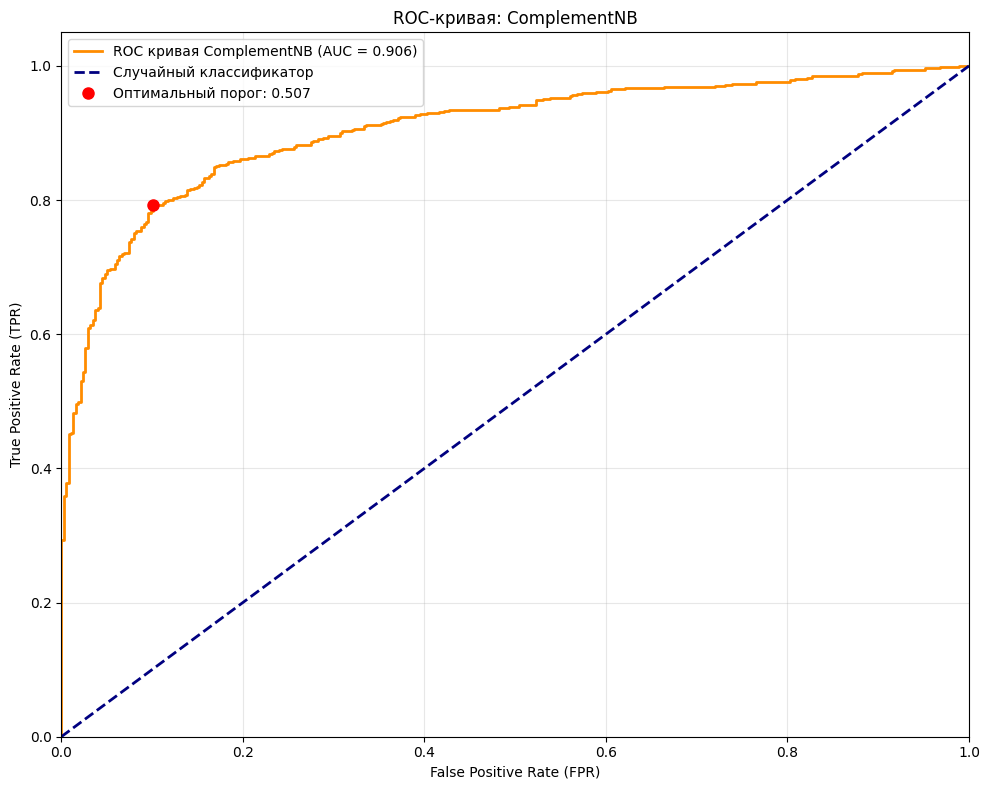

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       375
           1       0.89      0.85      0.87       625

    accuracy                           0.84      1000
   macro avg       0.83      0.84      0.83      1000
weighted avg       0.84      0.84      0.84      1000

ОБУЧАЮЩАЯ: 


C:\Users\maksg\AppData\Local\Temp\ipykernel_18056\3227939781.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_metrics = pd.concat([total_metrics, pd.DataFrame([get_metrics(model, X_test_scaled, y_test, "ComplementNB")])], ignore_index=True)


<Figure size 800x600 with 0 Axes>

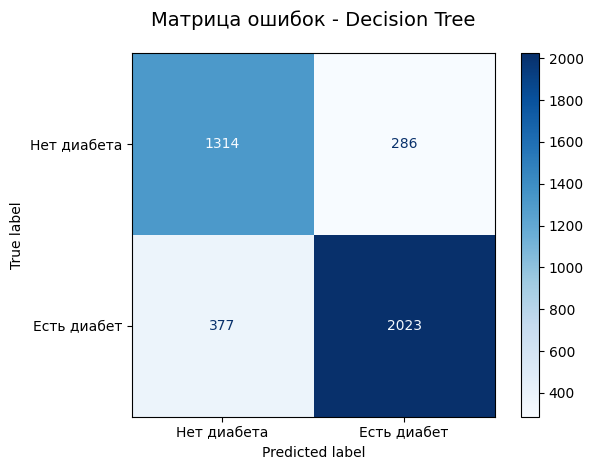

TECТОВАЯ: 


<Figure size 800x600 with 0 Axes>

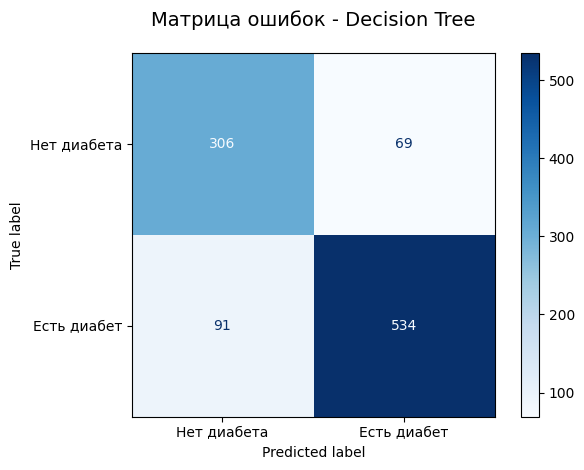

In [20]:
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gaus = ComplementNB()
model = gaus.fit(X_train_scaled, y_train)
y_pred = gaus.predict(X_test_scaled)
y_pred_train = gaus.predict(X_train_scaled)

total_metrics = pd.concat([total_metrics, pd.DataFrame([get_metrics(model, X_test_scaled, y_test, "ComplementNB")])], ignore_index=True)

print(classification_report(y_test, y_pred))

print("ОБУЧАЮЩАЯ: ")
show_matrix(y_train, y_pred_train)
print("TECТОВАЯ: ")
show_matrix(y_test, y_pred)

## **DecisionTree**

####  Дерево решений — это метод представления решающих правил в иерархической структуре, состоящей из элементов двух типов — узлов (node) и листьев (leaf). В узлах находятся решающие правила и производится проверка соответствия примеров этому правилу по какому-либо атрибуту обучающего множества. В простейшем случае, в результате проверки, множество примеров, попавших в узел, разбивается на два подмножества, в одно из которых попадают примеры, удовлетворяющие правилу, а в другое — не удовлетворяющие.

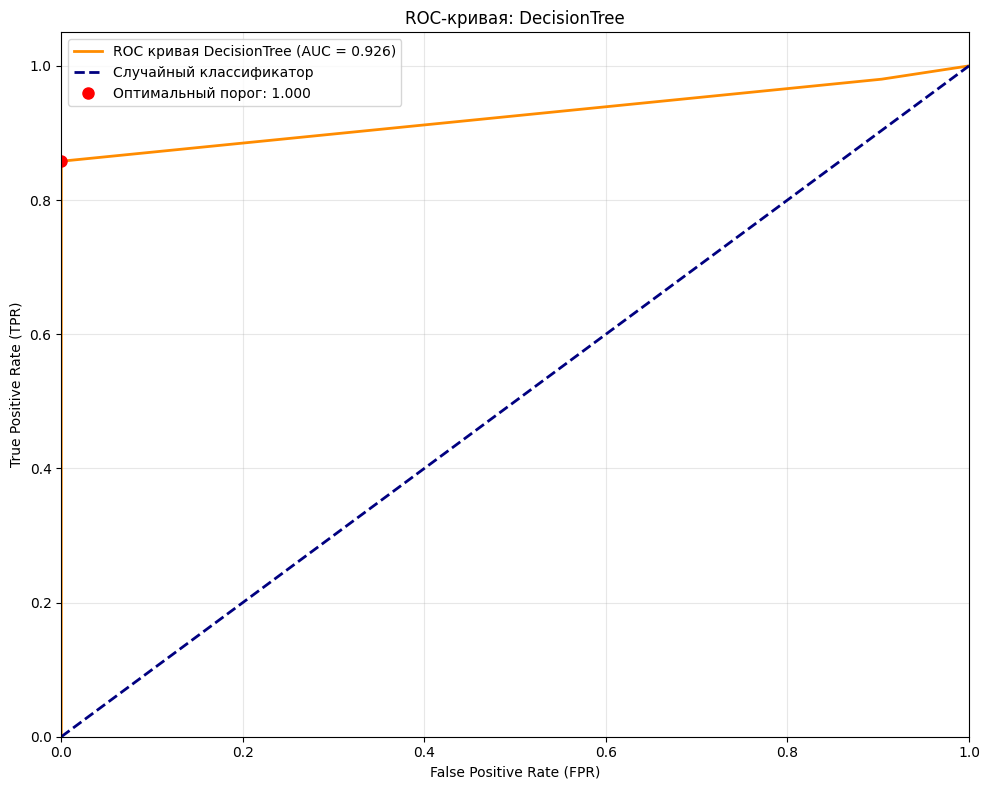

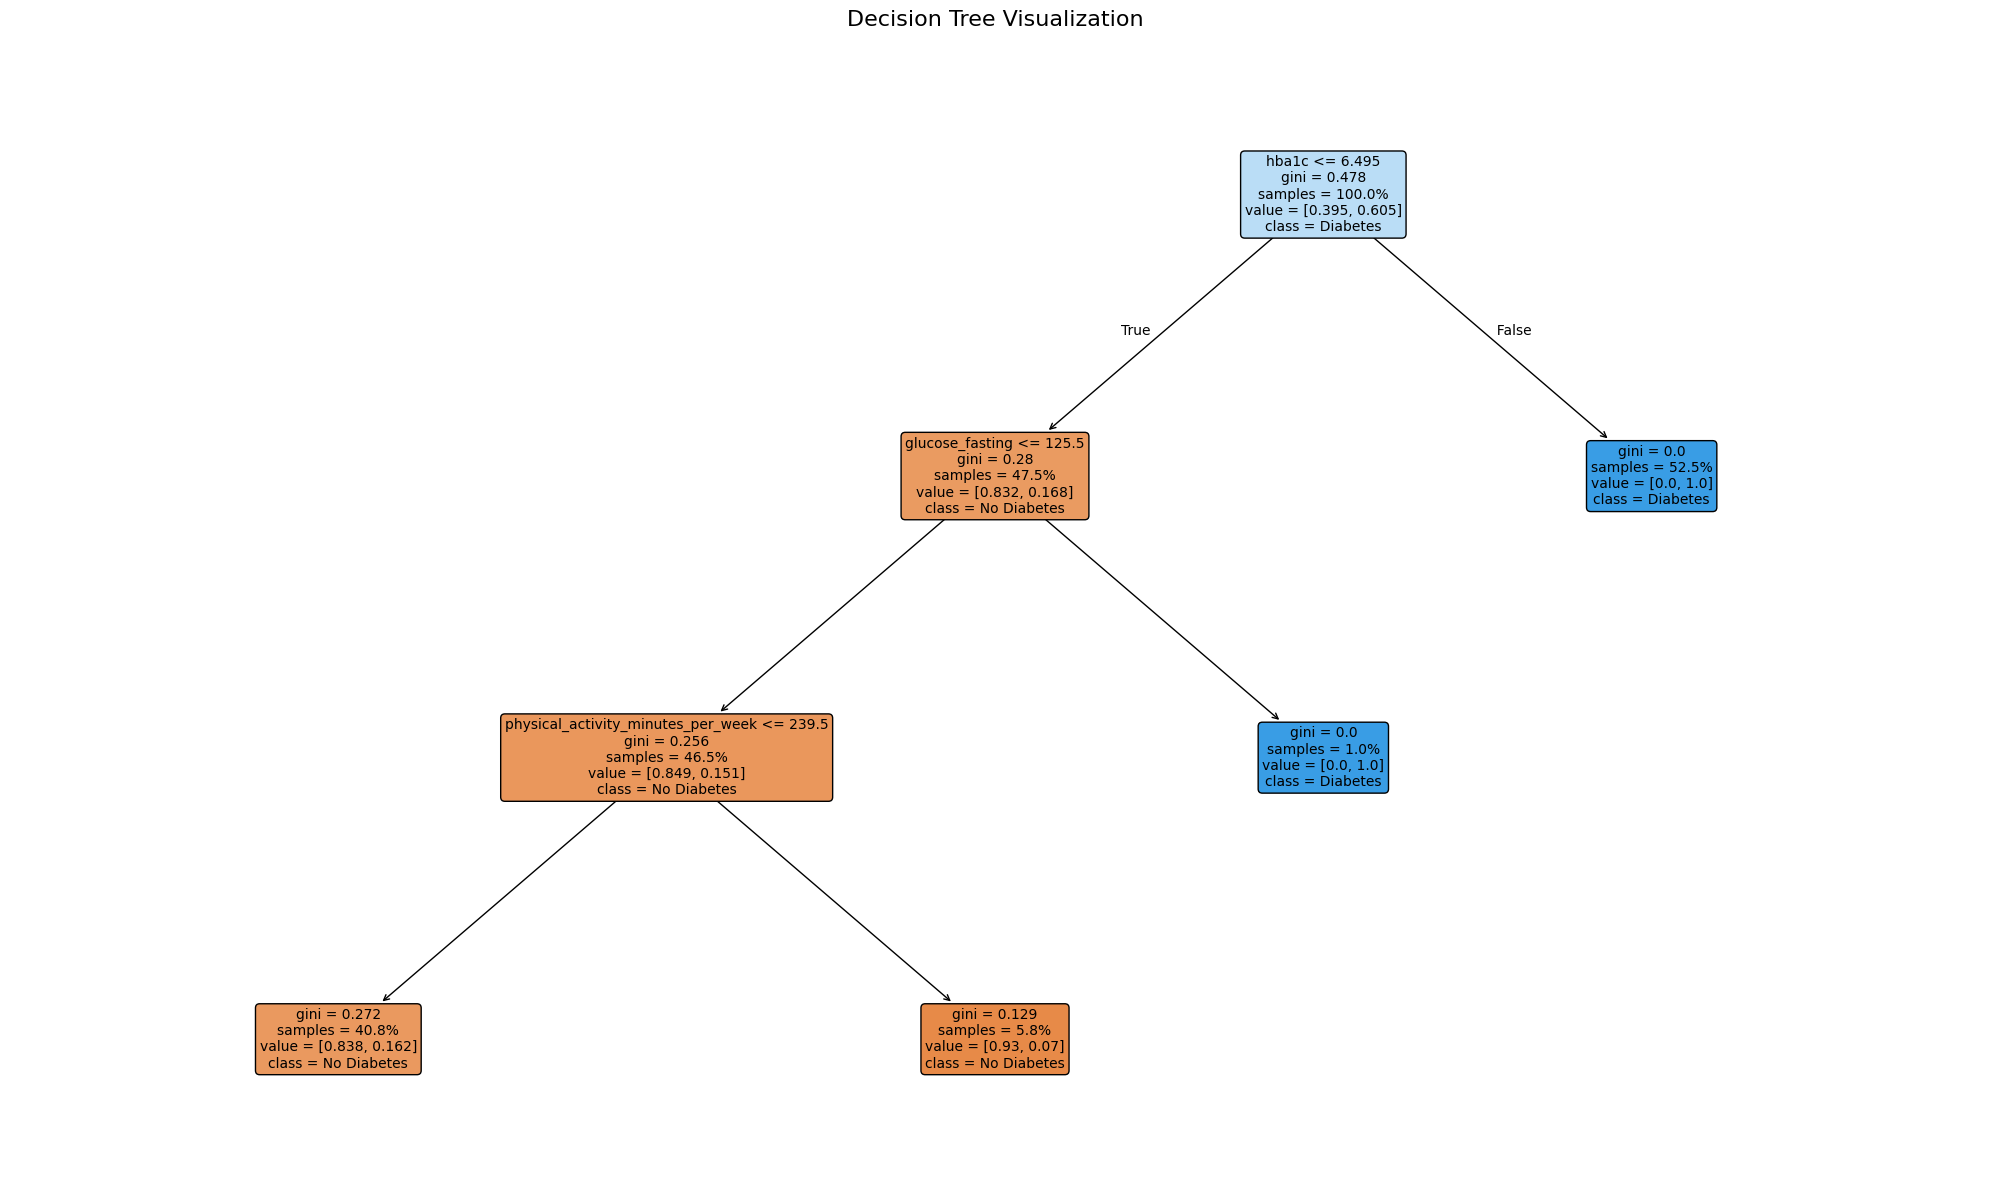

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       395
           1       1.00      0.86      0.92       605

    accuracy                           0.91      1000
   macro avg       0.91      0.93      0.91      1000
weighted avg       0.93      0.91      0.91      1000

ОБУЧАЮЩАЯ: 


<Figure size 800x600 with 0 Axes>

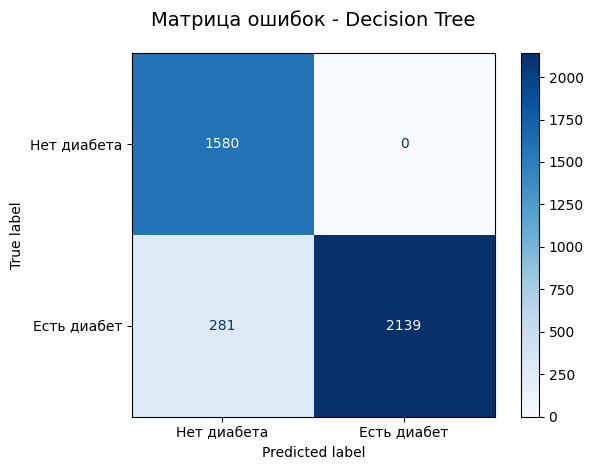

TECТОВАЯ: 


<Figure size 800x600 with 0 Axes>

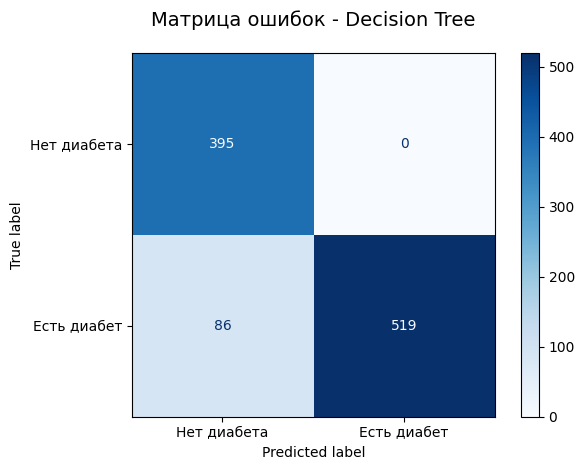

In [21]:
tree_data = X
X_train, X_test, y_train, y_test = train_test_split(
    tree_data, y, test_size=test_size, random_state=42, stratify=y
)

dt_model = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features=None,
    criterion='gini',
    random_state=42
)

dt_model.fit(X_train, y_train)

total_metrics = pd.concat([total_metrics, pd.DataFrame([get_metrics(dt_model, X_test, y_test, "DecisionTree")])], ignore_index=True)

plt.figure(figsize=(20, 12))
plot_tree(dt_model,
          feature_names=tree_data.columns.tolist(),
          class_names=['No Diabetes', 'Diabetes'],  # замените на ваши классы
          filled=True,
          rounded=True,
          max_depth=5,
          fontsize=10,
          proportion=True)

plt.title("Decision Tree Visualization", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

y_pred = dt_model.predict(X_test)
y_pred_train = dt_model.predict(X_train)
print(classification_report(y_test, y_pred))

print("ОБУЧАЮЩАЯ: ")
show_matrix(y_train, y_pred_train)
print("TECТОВАЯ: ")
show_matrix(y_test, y_pred)

#### Индекс Gini на конечных листах дерева принимает значения близкие к 0, что говорит о качестве подстроенного дерева. Если посмотреть на вероятности классов в листах, видно что всегда сильно лидирует один класс.

## **LDA**

#### Линейный дискриминантный анализ (ЛДА), а также связанный с ним линейный дискриминант Фишера — методы статистики и машинного обучения для нахождения линейных комбинаций признаков, наилучшим образом разделяющих два или более класса объектов или событий. Полученная комбинация может быть использована в качестве линейного классификатора или для сокращения размерности пространства признаков перед последующей классификацией.
#### Основной целью дискриминации является поиск линейной комбинации признаков (называемых дискриминантными признаками), которые позволили бы наилучшим образом разделить рассматриваемые группы.

#### Пример дискриминативной функции:
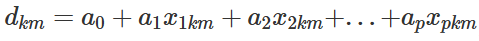

#### LDA определяет границу решений, основываясь на которой можно определить к какому классу принадлежит набор признаков.

### **Данные были сбалансированы с помощью SMOTE**
#### Это было сделано для того, чтобы сбалансировать классы, так как в классах сильный разброс (1975 vs 3025). Без балансировки точность была хуже. 


БАЛАНСИРОВКА ДАННЫХ:
До балансировки - классы в train:
Класс 0: 1580, Класс 1: 2420
После балансировки SMOTE - классы в train:
Класс 0: 2420, Класс 1: 2420

КОЭФФИЦИЕНТЫ LDA:
hba1c                         :     2.4770
glucose_postprandial          :     0.2821
glucose_fasting               :     0.2624
physical_activity_minutes_per_week:    -0.1203
bmi                           :     0.0781
screen_time_hours_per_day     :     0.0712
triglycerides                 :    -0.0199
insulin_level                 :    -0.0031
cholesterol_total             :    -0.0142
age                           :     0.0344
diet_score                    :     0.0277
ldl_cholesterol               :     0.0433
systolic_bp                   :    -0.0381
hdl_cholesterol               :     0.0135
sleep_hours_per_day           :     0.0949
heart_rate                    :    -0.0068
diastolic_bp                  :    -0.0187
waist_to_hip_ratio            :    -0.0534


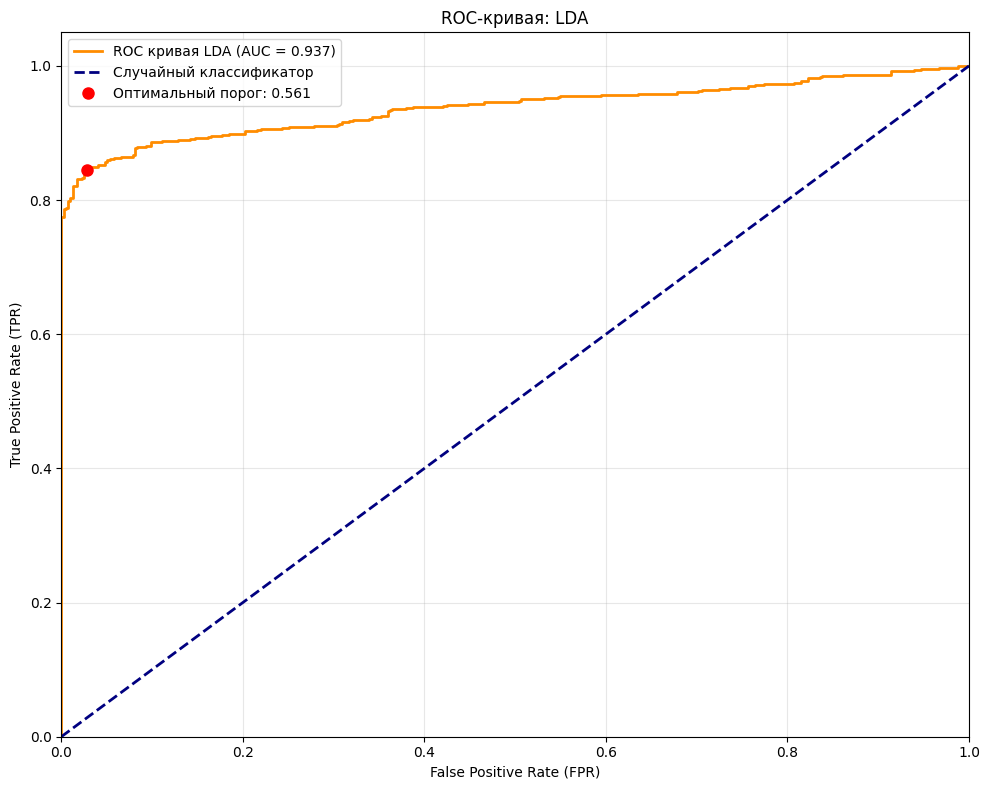

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       395
           1       0.94      0.88      0.91       605

    accuracy                           0.89      1000
   macro avg       0.89      0.90      0.89      1000
weighted avg       0.90      0.89      0.89      1000

ОБУЧАЮЩАЯ: 


<Figure size 800x600 with 0 Axes>

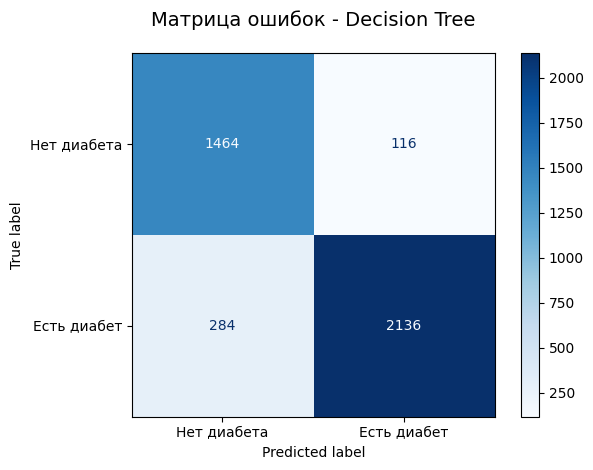

TECТОВАЯ: 


<Figure size 800x600 with 0 Axes>

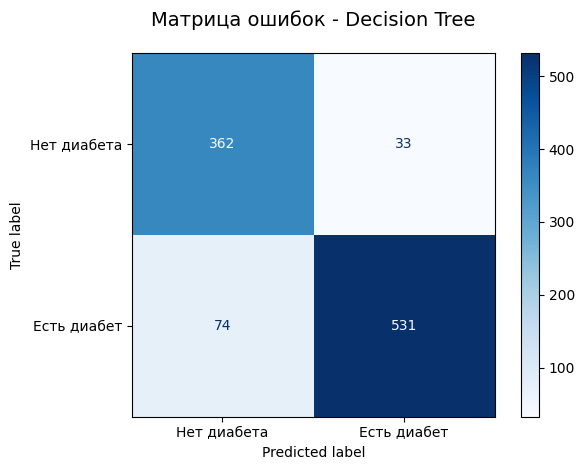

In [22]:
lda_data = X

X_train, X_test, y_train, y_test = train_test_split(
    lda_data, y, test_size=test_size, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nБАЛАНСИРОВКА ДАННЫХ:")
print("До балансировки - классы в train:")
print(f"Класс 0: {sum(y_train == 0)}, Класс 1: {sum(y_train == 1)}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("После балансировки SMOTE - классы в train:")
print(f"Класс 0: {sum(y_train_balanced == 0)}, Класс 1: {sum(y_train_balanced == 1)}")

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_balanced, y_train_balanced)

print("\nКОЭФФИЦИЕНТЫ LDA:")
feature_names = lda_data.columns
for i, (feature, coef) in enumerate(zip(feature_names, lda_model.coef_[0])):
    print(f"{feature:30}: {coef:10.4f}")
    
y_pred = lda_model.predict(X_test_scaled)
y_pred_train = lda_model.predict(X_train_scaled)

total_metrics = pd.concat([total_metrics, pd.DataFrame([get_metrics(lda_model, X_test_scaled, y_test, "LDA")])], ignore_index=True)
print(classification_report(y_test, y_pred))

print("ОБУЧАЮЩАЯ: ")
show_matrix(y_train, y_pred_train)
print("TECТОВАЯ: ")
show_matrix(y_test, y_pred)

### **Отобразим график с границей принятия решений**
#### Так как график представлен в 2D формате, а признаков у нас больше, чем 2, то будет применен метод главных компонент, чтобы объединить все признаки в две компоненты.

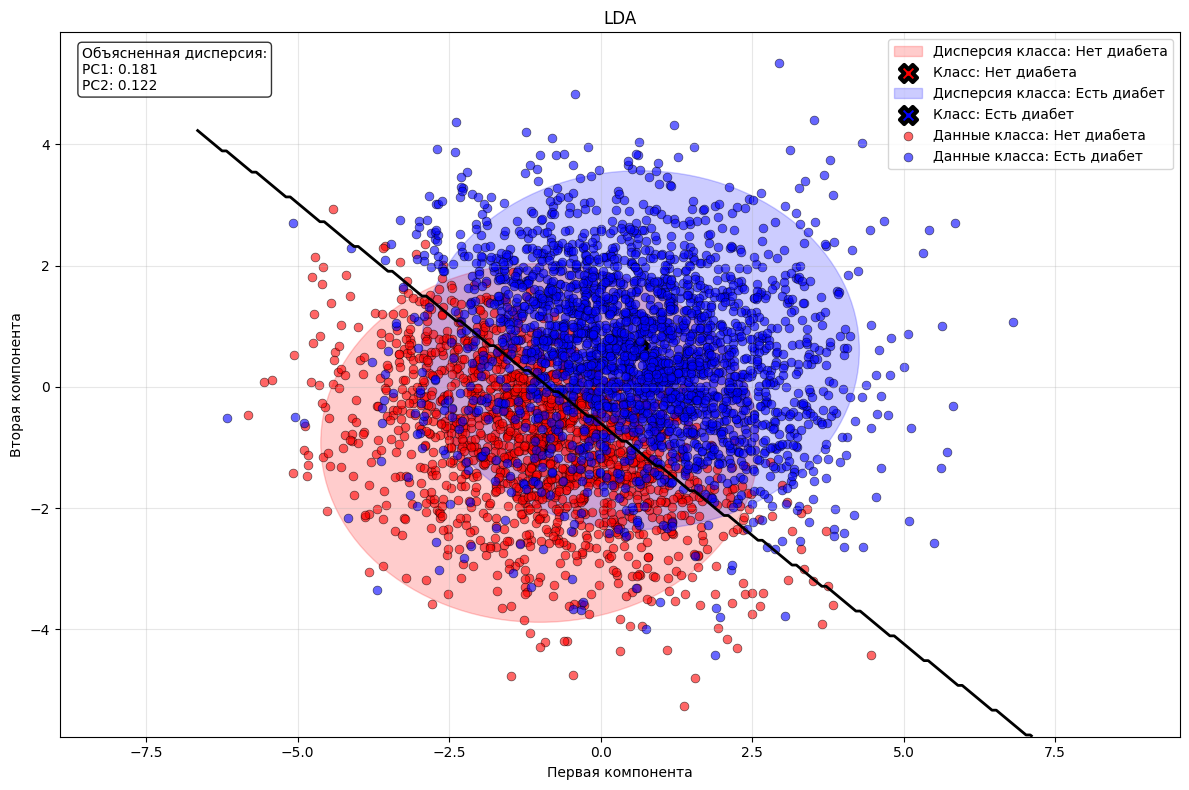

In [23]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

lda_pca = LinearDiscriminantAnalysis()
lda_pca.fit(X_train_pca, y_train)

means_pca = lda_pca.means_
covariance_pca = np.cov(X_train_pca.T)

plt.figure(figsize=(12, 8))

colors = ['red', 'blue']

for i, color in enumerate(colors):
    if i < len(means_pca):
        cov = covariance_pca

        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        
        width, height = 2 * 2 * np.sqrt(eigvals)
        
        ellipse = Ellipse(xy=means_pca[i], width=width, height=height, 
                         angle=angle, alpha=0.2, color=color,
                         label=f'Дисперсия класса: {"Нет диабета" if i == 0 else "Есть диабет"}'
                         )
        plt.gca().add_patch(ellipse)
        
        plt.scatter(means_pca[i, 0], means_pca[i, 1], c=color, s=150,
                   marker='X', linewidth=3, label=f'Класс: {"Нет диабета" if i == 0 else "Есть диабет"}',
                   edgecolors='black')

x_min, x_max = X_train_pca[:, 0].min() - 0.5, X_train_pca[:, 0].max() + 0.5
y_min, y_max = X_train_pca[:, 1].min() - 0.5, X_train_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = lda_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='-')

for i, color in enumerate(colors):
    if i < len(lda_pca.classes_):
        class_mask = y_train == lda_pca.classes_[i]
        plt.scatter(X_train_pca[class_mask, 0], X_train_pca[class_mask, 1],
                   c=color, alpha=0.6, s=40, edgecolors='black', linewidth=0.5,
                   label=f'Данные класса: {"Нет диабета" if i == 0 else "Есть диабет"}')

plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.title('LDA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

explained_variance = pca.explained_variance_ratio_
plt.text(0.02, 0.98, f'Объясненная дисперсия:\nPC1: {explained_variance[0]:.3f}\nPC2: {explained_variance[1]:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

#### Хоть эта модель и построенна с помощью PCA, LDA построил достаточно точную линию принятия решений. Линия разделяет между собой классы, есть неверные данные, но большинство данных находятся в своей области.

## **Метод опорных векторов (Support Vector Machines)**

#### Метод опорных векторов (Support Vector Machines - SVM) - это набор методов контролируемого обучения, используемых для классификации, регрессии и выявления выбросов.

#### Иногда данные так расположены, что нельзя провести прямую линию, которая бы четко разделила их на две группы. Например, если точки расположены в виде окружности, то прямая линия не сможет их разделить на внутренние и внешние. В этом случае SVM может использовать нелинейные функции для преобразования данных в более высокоразмерное пространство. Визуально это выглядит так, как будто двумерная окружность вытягивается в трёхмерное пространство и превращается в цилиндр. В таком виде плоскость может легко разделить точки внутри цилиндра и снаружи.

#### Преимуществами Метода опорных векторов являются:

- Эффективны в пространствах высокой размерности.

- По-прежнему эффективны в случаях, когда число измерений больше числа выборок.

- Использует подмножество обучающих точек в функции принятия решений (называемых опорными векторами), поэтому также эффективна с точки зрения памяти.

- Универсальность: для функции принятия решений могут быть заданы различные Функциональные ядра. Предоставляются общие ядра, но можно указать и собственные.

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       395
           1       0.91      0.88      0.89       605

    accuracy                           0.88      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.88      0.88      0.88      1000

ОБУЧАЮЩАЯ: 


<Figure size 800x600 with 0 Axes>

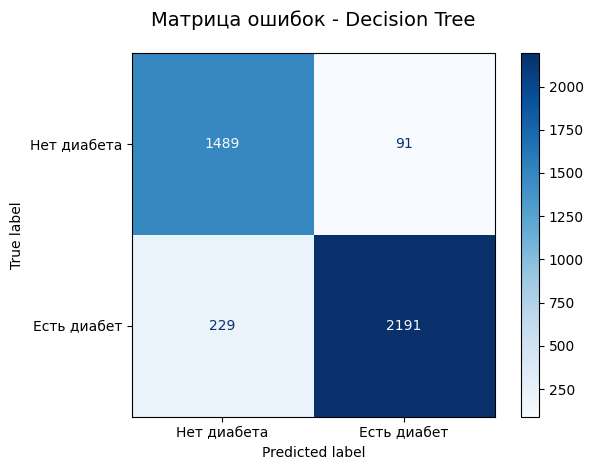

TECТОВАЯ: 


<Figure size 800x600 with 0 Axes>

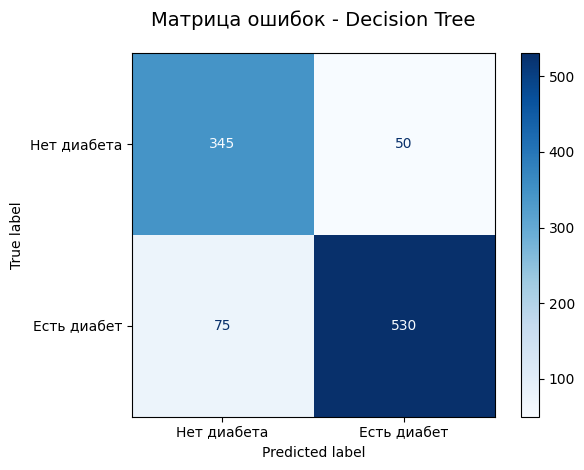

In [24]:
svc_data = tree_data

svc_model = SVC(random_state=42)
svc_model.fit(X_train_scaled, y_train)

y_test_pred = svc_model.predict(X_test_scaled)
y_train_pred = svc_model.predict(X_train_scaled)
y_test_scores = svc_model.decision_function(X_test_scaled)

total_metrics = pd.concat([total_metrics, pd.DataFrame([get_metrics(svc_model, X_test_scaled, y_test, "SVM")])], ignore_index=True)

roc_auc = roc_auc_score(y_test, y_test_scores)
total_metrics.loc[3, 'roc_auc'] = roc_auc


print(classification_report(y_test, y_test_pred))

print("ОБУЧАЮЩАЯ: ")
show_matrix(y_train, y_train_pred)
print("TECТОВАЯ: ")
show_matrix(y_test, y_test_pred)

#### **Также переведем признаки в две компоненты с помощью PCA для отображения графика**

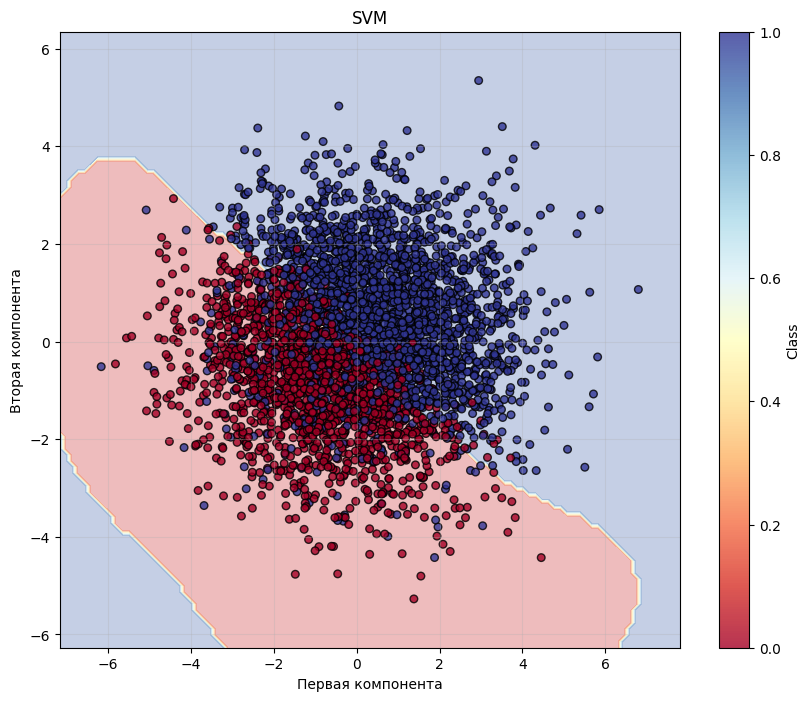

In [25]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc_model = SVC(random_state=42)
svc_model.fit(X_train_pca, y_train)

plt.figure(figsize=(10, 8))

DecisionBoundaryDisplay.from_estimator(
    svc_model,
    X_train_pca,
    response_method="predict",
    cmap=plt.cm.RdYlBu,
    alpha=0.3,
    ax=plt.gca()
)

scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                     c=y_train, cmap=plt.cm.RdYlBu, 
                     edgecolors='black', s=30, alpha=0.8)

plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.title('SVM')
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.show()

#### Здесь использовалось ядро Radial Basis Function (rbf). Граница решений примерно совпадает с границей решений с LDA. Вероятно, для этой задачи не было необходимости использовать нелинейной ядро.

## **Метод ближайших соседей (k-Nearest Neighbors)**

#### К-ближайших соседей (K-Nearest Neighbors или просто KNN) — алгоритм классификации и регрессии, основанный на гипотезе компактности, которая предполагает, что расположенные близко друг к другу объекты в пространстве признаков имеют схожие значения целевой переменной или принадлежат к одному классу.

#### Алгоритм строится следующим образом:

- сначала вычисляется расстояние между тестовым и всеми обучающими образцами;

- далее из них выбирается k-ближайших образцов (соседей), где число k задаётся заранее;

- итоговым прогнозом среди выбранных k-ближайших образцов будет мода в случае классификации и среднее арифметическое в случае регрессии;

- предыдущие шаги повторяются для всех тестовых образцов.

#### Сначало будет логично определить количество соседей, с которыми нужно сравнивать образцы.

Оптимальное k: 18


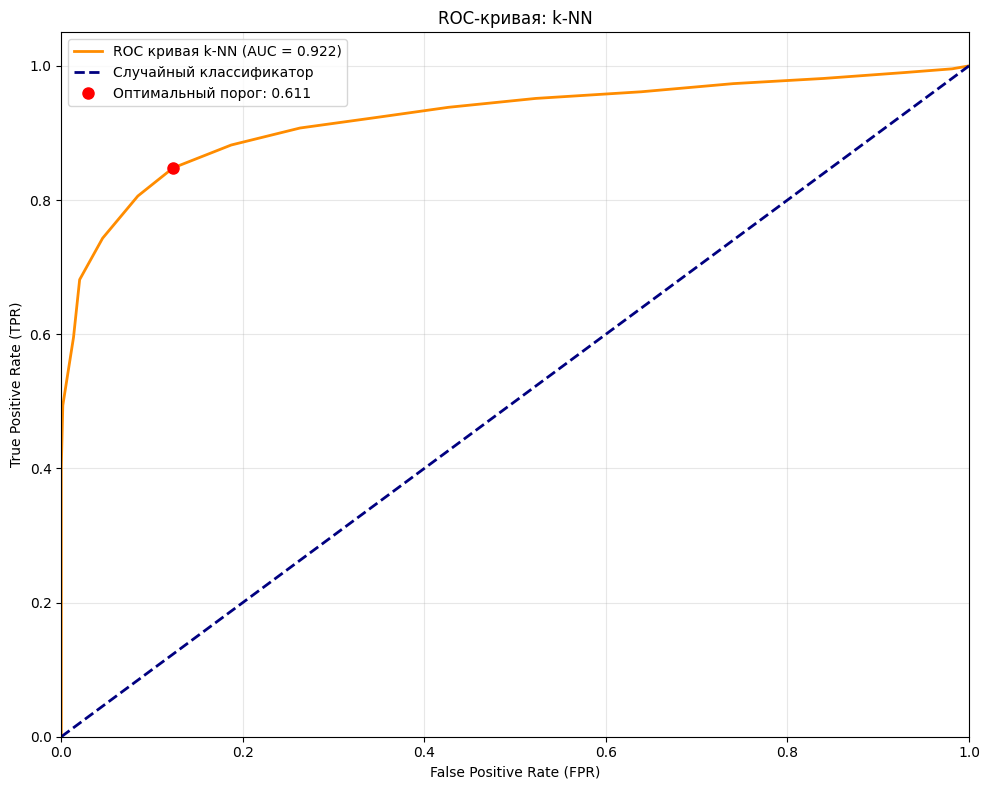

Модель k-NN обучена с k = 18
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       593
           1       0.88      0.88      0.88       907

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500

ОБУЧАЮЩАЯ: 


<Figure size 800x600 with 0 Axes>

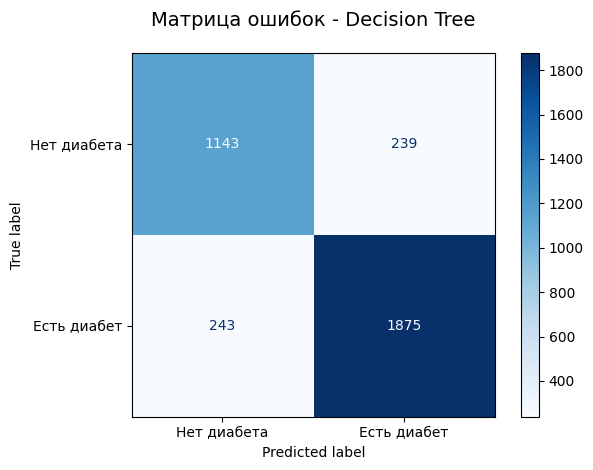

TECТОВАЯ: 


<Figure size 800x600 with 0 Axes>

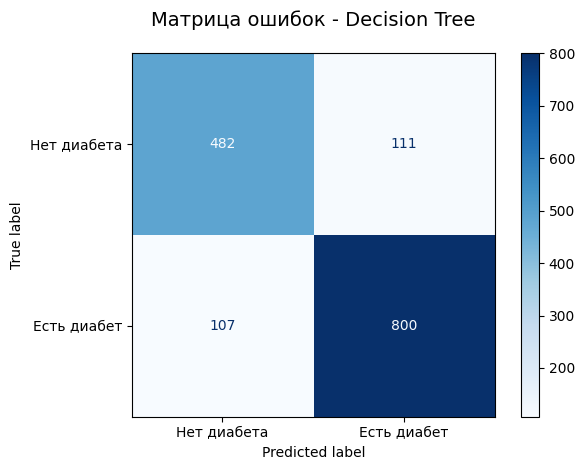

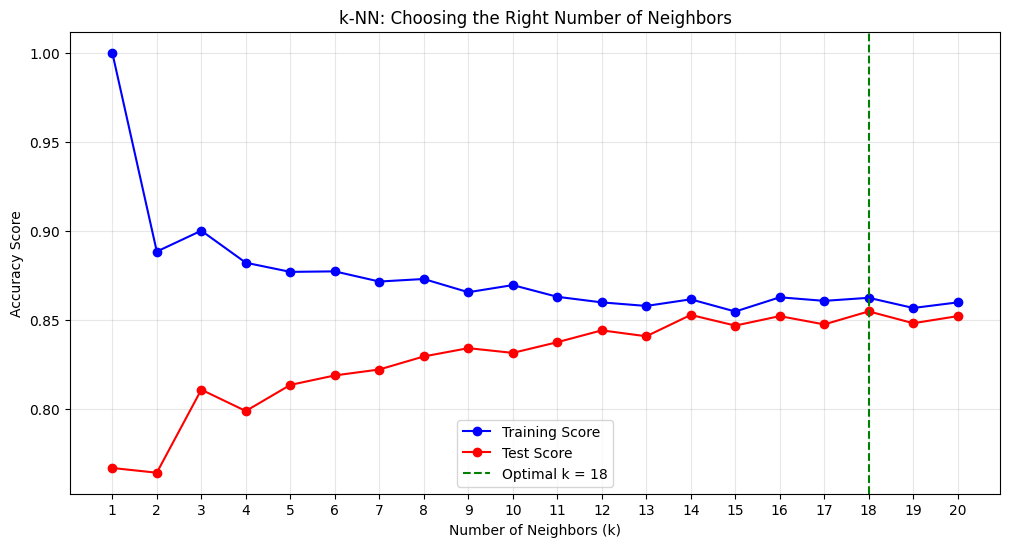

In [26]:
kNN_data = tree_data

X_train, X_test, y_train, y_test = train_test_split(
    kNN_data, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_range = range(1, 21)
train_scores = []
test_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_k = k_range[np.argmax(test_scores)]
print(f"Оптимальное k: {optimal_k}")

knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train)

total_metrics = pd.concat([total_metrics, pd.DataFrame([get_metrics(knn_model, X_test_scaled, y_test, "k-NN")])], ignore_index=True)

print(f"Модель k-NN обучена с k = {optimal_k}")

y_test_pred = knn_model.predict(X_test_scaled)
y_train_pred = knn_model.predict(X_train_scaled)
y_test_proba = knn_model.predict_proba(X_test_scaled)


print(classification_report(y_test, y_test_pred))

print("ОБУЧАЮЩАЯ: ")
show_matrix(y_train, y_train_pred)
print("TECТОВАЯ: ")
show_matrix(y_test, y_test_pred)

plt.figure(figsize=(12, 6))
plt.plot(k_range, train_scores, 'o-', label='Training Score', color='blue')
plt.plot(k_range, test_scores, 'o-', label='Test Score', color='red')
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.title('k-NN: Choosing the Right Number of Neighbors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

#### Оптимальное кол-во соседей 18. По графику видно, что точность в этом месте межу тестовой и обучающей ближе чем в других.

## **СРАВНЕНИЕ МЕТРИК**

In [27]:
total_metrics

,model,accuracy,precision,recall,f1,roc_auc
0,ComplementNB,0.840000,0.885572,0.854400,0.869707,0.905519
1,DecisionTree,0.914000,1.000000,0.857851,0.923488,0.925846
2,LDA,0.893000,0.941489,0.877686,0.908469,0.937454
3,SVM,0.875000,0.913793,0.876033,0.894515,0.931863
4,k-NN,0.854667,0.878156,0.882029,0.880088,0.921632


#### Сравнивая все модели и их метрики, можно сделать вывод, что для данной задачи лучше всего подходит метод Деревья решений.

#### **ТОП-5 МЕТОДОВ!**
- #### Desicion TREE
- #### LDA
- #### SVM
- #### Наивный Байесовский Метод
- #### k-NN

## **ИЗУЧЕНИЕ ВЛИЯНИЯ ГИПЕРПАРАМЕТРОВ**

#### **Наивный Байевский классификатор**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


Лучшие параметры: {'var_smoothing': np.float64(7.847599703514607e-08)}
Лучший F1-score: 0.8739


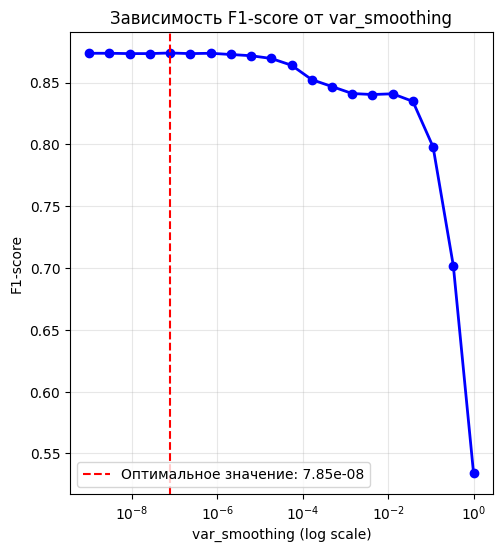

In [29]:
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 20)  # от 1e-9 до 1
}

grid_search = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print(f"Лучший F1-score: {grid_search.best_score_:.4f}")

results_df = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.semilogx(results_df['param_var_smoothing'], results_df['mean_test_score'], 'bo-', linewidth=2, markersize=6)
plt.axvline(grid_search.best_params_['var_smoothing'], color='red', linestyle='--', 
            label=f'Оптимальное значение: {grid_search.best_params_["var_smoothing"]:.2e}')
plt.xlabel('var_smoothing (log scale)')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от var_smoothing')
plt.grid(True, alpha=0.3)
plt.legend()

#### **Decision Tree**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    tree_data, y, test_size=test_size, random_state=42, stratify=y
)

param_grid_fast = {
    'criterion': ['gini'],
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 0.5]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_fast,
    cv=2,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)

top_results = results_df.nlargest(20, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'mean_fit_time']
]

print("Топ-20 комбинаций параметров:")
for i, (idx, row) in enumerate(top_results.iterrows(), 1):
    params = row['params']
    print(f"{i:2d}. F1: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f} | "
          f"Train: {row['mean_train_score']:.4f} | "
          f"Time: {row['mean_fit_time']:.3f}s")
    print(f"    Params: {params}")
    print()

Fitting 2 folds for each of 162 candidates, totalling 324 fits
Топ-20 комбинаций параметров:
 1. F1: 0.9305 ± 0.0052 | Train: 0.9305 | Time: 0.008s
    Params: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}

 2. F1: 0.9305 ± 0.0052 | Train: 0.9305 | Time: 0.009s
    Params: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10}

 3. F1: 0.9305 ± 0.0052 | Train: 0.9305 | Time: 0.010s
    Params: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 20}

 4. F1: 0.9300 ± 0.0047 | Train: 0.9309 | Time: 0.009s
    Params: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

 5. F1: 0.9300 ± 0.0047 | Train: 0.9309 | Time: 0.008s
    Params: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

 6. F1: 0.9300 ± 0.0047 | 

#### **LDA**


БАЛАНСИРОВКА ДАННЫХ:
До балансировки - классы в train:
Класс 0: 1580, Класс 1: 2420
Fitting 5 folds for each of 54 candidates, totalling 270 fits

ЛУЧШИЕ ПАРАМЕТРЫ LDA
Best parameters: {'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}

=== РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ===
Accuracy: 0.8930
F1-score: 0.9085
ROC-AUC: 0.9375

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       395
           1       0.94      0.88      0.91       605

    accuracy                           0.89      1000
   macro avg       0.89      0.90      0.89      1000
weighted avg       0.90      0.89      0.89      1000

Топ-10 комбинаций параметров:
param_solver param_shrinkage  param_store_covariance  param_tol  mean_test_score  std_test_score
         svd             NaN                    True     0.0001         0.905744        0.010268
         svd             NaN                    True     0.0010         0.905744        0.

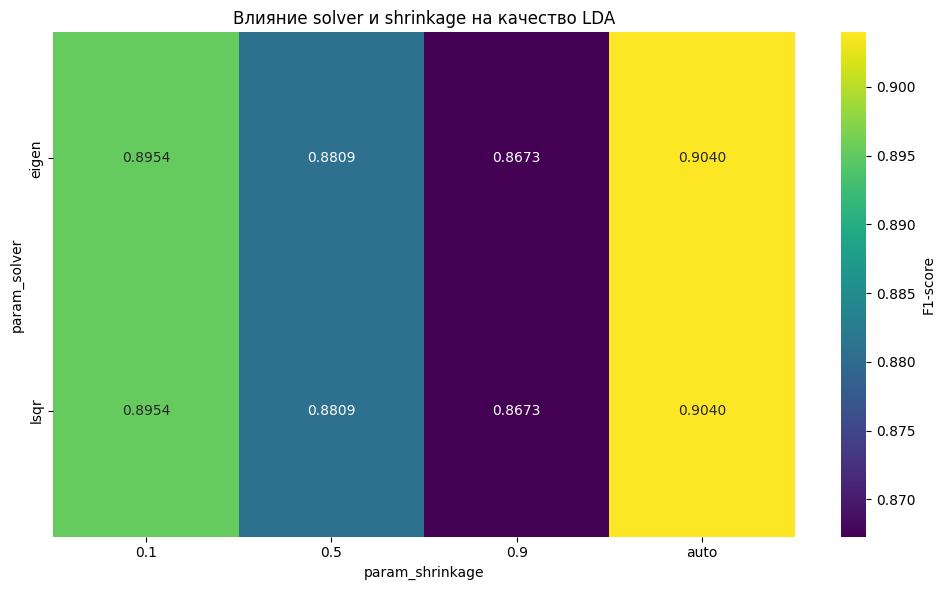

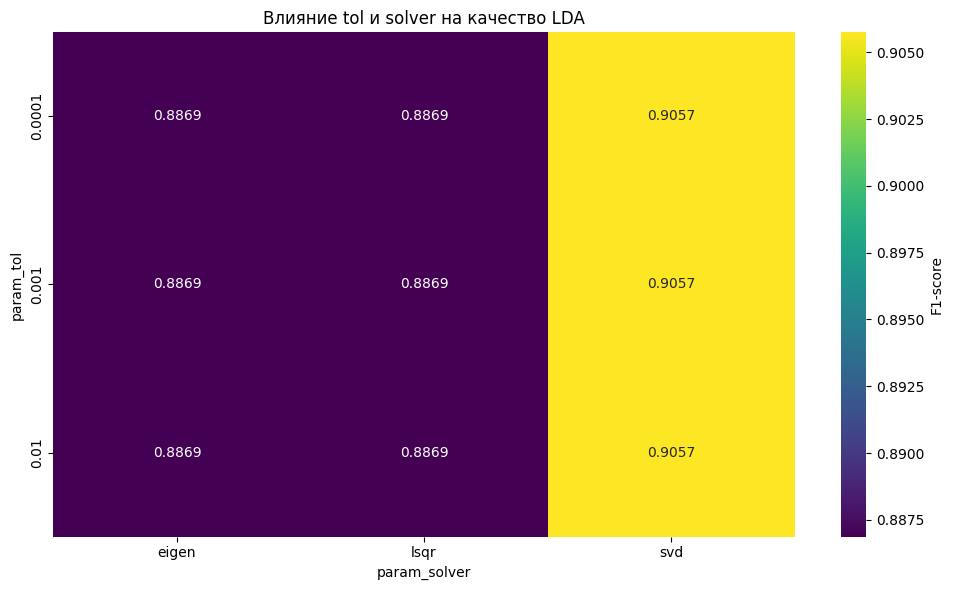

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    lda_data, y, test_size=test_size, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nБАЛАНСИРОВКА ДАННЫХ:")
print("До балансировки - классы в train:")
print(f"Класс 0: {sum(y_train == 0)}, Класс 1: {sum(y_train == 1)}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

param_grid = [
    {
        'solver': ['svd'],
        'store_covariance': [True, False],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    {
        'solver': ['lsqr', 'eigen'],
        'shrinkage': ['auto', 0.1, 0.5, 0.9],
        'store_covariance': [True, False],
        'tol': [1e-4, 1e-3, 1e-2]
    }
]


grid_search = GridSearchCV(
    LinearDiscriminantAnalysis(),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

print("\nЛУЧШИЕ ПАРАМЕТРЫ LDA")
print(f"Best parameters: {grid_search.best_params_}")

best_lda = grid_search.best_estimator_
y_pred_best = best_lda.predict(X_test_scaled)
y_pred_proba_best = best_lda.predict_proba(X_test_scaled)[:, 1]

best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)
best_auc = roc_auc_score(y_test, y_pred_proba_best)

print(f"\n=== РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ===")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"F1-score: {best_f1:.4f}")
print(f"ROC-AUC: {best_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

results_df = pd.DataFrame(grid_search.cv_results_)

# Топ-10 комбинаций параметров
top_results = results_df.nlargest(10, 'mean_test_score')[
    ['param_solver', 'param_shrinkage', 'param_store_covariance', 
     'param_tol', 'mean_test_score', 'std_test_score']
]

print("Топ-10 комбинаций параметров:")
print(top_results.to_string(index=False))

# Визуализация влияния solver и shrinkage
pivot_data = results_df.pivot_table(
    index='param_solver',
    columns='param_shrinkage', 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='viridis', cbar_kws={'label': 'F1-score'})
plt.title('Влияние solver и shrinkage на качество LDA')
plt.tight_layout()
plt.show()

pivot_data = results_df.pivot_table(
    index='param_tol',
    columns='param_solver', 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='viridis', cbar_kws={'label': 'F1-score'})
plt.title('Влияние tol и solver на качество LDA')
plt.tight_layout()
plt.show()

#### **k-NN**



ПОДБОР ОПТИМАЛЬНОГО КОЛИЧЕСТВА СОСЕДЕЙ (k) - БАЗОВЫЙ СПОСОБ
Оптимальное k (базовый способ): 18

ПОДБОР ГИПЕРПАРАМЕТРОВ ЧЕРЕЗ GRIDSEARCHCV
Запуск GridSearchCV...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits

РЕЗУЛЬТАТЫ GRIDSEARCHCV
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 28, 'p': 1, 'weights': 'uniform'}
Лучшая оценка (F1-weighted): 0.8655

ОБУЧЕНИЕ ФИНАЛЬНОЙ k-NN МОДЕЛИ

ОЦЕНКА КАЧЕСТВА МОДЕЛИ
Accuracy: 0.8673
Precision: 0.8907
Recall: 0.8897
F1-Score: 0.8902

ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       593
           1       0.89      0.89      0.89       907

    accuracy                           0.87      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.87      0.87      0.87      1500


МАТРИЦА ОШИБОК
[[494  99]
 [100 807]]

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ПОДБОРА ПАРАМЕТРОВ


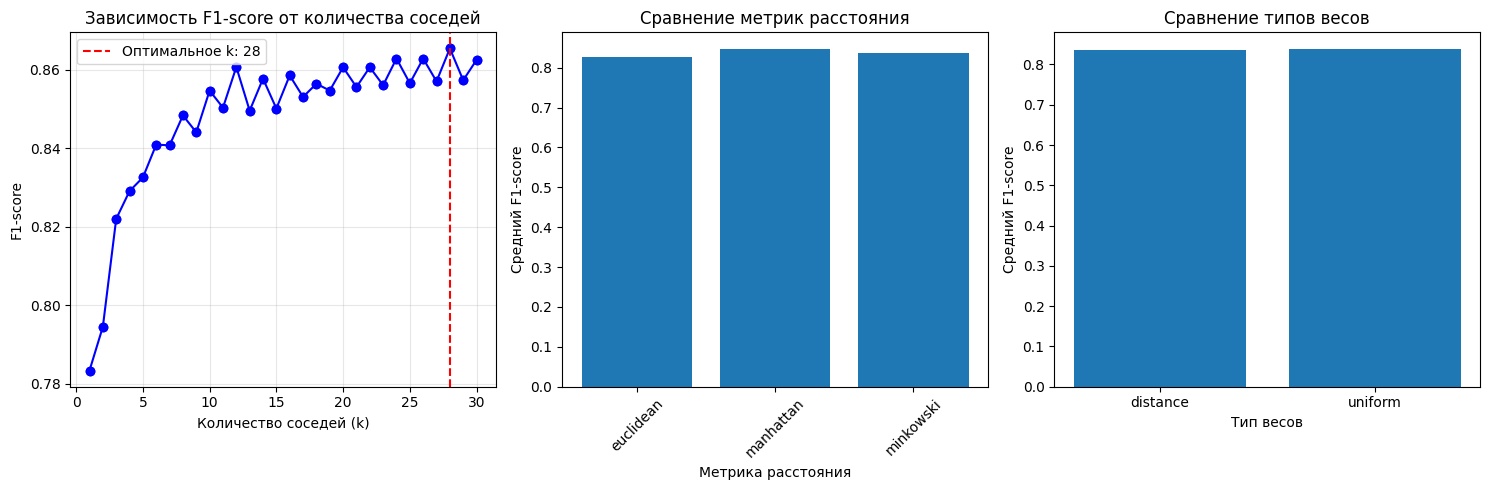


СРАВНЕНИЕ РЕЗУЛЬТАТОВ
Базовый подход (k=18):
  Accuracy: 0.8547
GridSearchCV подход (k=28):
  Accuracy: 0.8673
Улучшение: 0.0127

АНАЛИЗ ВАЖНОСТИ ПАРАМЕТРОВ
Топ-10 лучших комбинаций параметров:
 param_n_neighbors param_weights param_metric  mean_test_score  std_test_score
                28       uniform    manhattan         0.865500        0.012824
                28       uniform    manhattan         0.865500        0.012824
                28       uniform    minkowski         0.865500        0.012824
                24       uniform    manhattan         0.862927        0.013829
                24       uniform    manhattan         0.862927        0.013829
                24       uniform    minkowski         0.862927        0.013829
                26       uniform    manhattan         0.862909        0.013751
                26       uniform    manhattan         0.862909        0.013751
                26       uniform    minkowski         0.862909        0.013751
               

In [32]:


X_train, X_test, y_train, y_test = train_test_split(
    kNN_data, y, test_size=0.3, random_state=42, stratify=y
)

# Масштабирование признаков (ВАЖНО для k-NN!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ПОДБОР ОПТИМАЛЬНОГО K БАЗОВЫМ СПОСОБОМ
print("\n" + "="*50)
print("ПОДБОР ОПТИМАЛЬНОГО КОЛИЧЕСТВА СОСЕДЕЙ (k) - БАЗОВЫЙ СПОСОБ")
print("="*50)

k_range = range(1, 21)
train_scores = []
test_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

# Находим оптимальное k
optimal_k = k_range[np.argmax(test_scores)]
print(f"Оптимальное k (базовый способ): {optimal_k}")

# ПОДБОР ГИПЕРПАРАМЕТРОВ ЧЕРЕЗ GRIDSEARCHCV
print("\n" + "="*50)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ ЧЕРЕЗ GRIDSEARCHCV")
print("="*50)

# Определяем сетку параметров
param_grid = {
    'n_neighbors': range(1, 31),  # больше значений k
    'weights': ['uniform', 'distance'],  # тип весов
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # метрики расстояния
    'p': [1, 2]  # параметр для манхэттенского расстояния
}

# Создаем GridSearchCV
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,  # 5-кратная кросс-валидация
    scoring='f1_weighted',  # можно изменить на 'accuracy', 'precision', 'recall'
    n_jobs=-1,  # использовать все ядра процессора
    verbose=1  # вывод прогресса
)

# Запускаем поиск
print("Запуск GridSearchCV...")
grid_search.fit(X_train_scaled, y_train)

# Выводим результаты
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ GRIDSEARCHCV")
print("="*50)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая оценка (F1-weighted): {grid_search.best_score_:.4f}")

# ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ЛУЧШИМИ ПАРАМЕТРАМИ
print("\n" + "="*50)
print("ОБУЧЕНИЕ ФИНАЛЬНОЙ k-NN МОДЕЛИ")
print("="*50)

# Используем лучшие параметры из GridSearchCV
knn_model = grid_search.best_estimator_
knn_model.fit(X_train_scaled, y_train)

# Предсказания на тестовых данных
y_pred = knn_model.predict(X_test_scaled)
y_pred_proba = knn_model.predict_proba(X_test_scaled)

# ОЦЕНКА КАЧЕСТВА МОДЕЛИ
print("\n" + "="*50)
print("ОЦЕНКА КАЧЕСТВА МОДЕЛИ")
print("="*50)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Базовые метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Детальный отчет
print("\n" + "="*30)
print("ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ")
print("="*30)
print(classification_report(y_test, y_pred))

# Матрица ошибок
print("\n" + "="*30)
print("МАТРИЦА ОШИБОК")
print("="*30)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ GRIDSEARCH
print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ПОДБОРА ПАРАМЕТРОВ")
print("="*50)

import matplotlib.pyplot as plt
import pandas as pd

# Создаем DataFrame с результатами
results_df = pd.DataFrame(grid_search.cv_results_)

# Визуализация зависимости от n_neighbors
plt.figure(figsize=(15, 5))

# График 1: Зависимость от количества соседей
plt.subplot(1, 3, 1)
best_weights = grid_search.best_params_['weights']
best_metric = grid_search.best_params_['metric']

# Фильтруем результаты для лучших weights и metric
filtered_results = results_df[
    (results_df['param_weights'] == best_weights) & 
    (results_df['param_metric'] == best_metric)
]

plt.plot(filtered_results['param_n_neighbors'], filtered_results['mean_test_score'], 'bo-')
plt.axvline(grid_search.best_params_['n_neighbors'], color='red', linestyle='--', 
           label=f'Оптимальное k: {grid_search.best_params_["n_neighbors"]}')
plt.xlabel('Количество соседей (k)')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от количества соседей')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Сравнение метрик расстояния
plt.subplot(1, 3, 2)
metric_scores = results_df.groupby('param_metric')['mean_test_score'].mean()
plt.bar(metric_scores.index, metric_scores.values)
plt.xlabel('Метрика расстояния')
plt.ylabel('Средний F1-score')
plt.title('Сравнение метрик расстояния')
plt.xticks(rotation=45)

# График 3: Сравнение типов весов
plt.subplot(1, 3, 3)
weight_scores = results_df.groupby('param_weights')['mean_test_score'].mean()
plt.bar(weight_scores.index, weight_scores.values)
plt.xlabel('Тип весов')
plt.ylabel('Средний F1-score')
plt.title('Сравнение типов весов')

plt.tight_layout()
plt.show()

# Сравнение с базовым подходом
print("\n" + "="*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*50)

print(f"Базовый подход (k={optimal_k}):")
base_knn = KNeighborsClassifier(n_neighbors=optimal_k)
base_knn.fit(X_train_scaled, y_train)
base_score = base_knn.score(X_test_scaled, y_test)
print(f"  Accuracy: {base_score:.4f}")

print(f"GridSearchCV подход (k={grid_search.best_params_['n_neighbors']}):")
grid_score = knn_model.score(X_test_scaled, y_test)
print(f"  Accuracy: {grid_score:.4f}")

improvement = grid_score - base_score
print(f"Улучшение: {improvement:.4f}")

# Анализ важности параметров
print("\n" + "="*50)
print("АНАЛИЗ ВАЖНОСТИ ПАРАМЕТРОВ")
print("="*50)

# Топ-10 комбинаций параметров
top_10_results = results_df.nlargest(10, 'mean_test_score')[
    ['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score', 'std_test_score']
]
print("Топ-10 лучших комбинаций параметров:")
print(top_10_results.to_string(index=False))